# Apply of the CRISP-DM data mining methodology to analyse the data

In this notebook we're going to apply the steps of the CRISP-DM data mining methodology to analyse the data

The dataset we choose for this project: Stackoverflow. Link: https://demo.neo4jlabs.com:7473/browser/?dbms=neo4j://stackoverflow@demo.neo4jlabs.com&db=stackoverflow

# Installing necessary libraries

In [1]:
!pip install py2neo pandas
!pip install py2neo pandas matplotlib

# Loading necessary libraries

In [5]:
from py2neo import Graph

import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import pandas as pd
from collections import Counter
# from sklearn.ensemble import RandomForestClassifier

# from sklearn.metrics import recall_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import roc_auc_score

# Section-1: Loading the database into our local neo4j database
In this section, at first, we created a local database into our Neo4j Desktop named: stackoverflowdb. We choose the db version: 4.1.0

Then apply the following credentials to connnect to our local database:

In [6]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "87654321")) 

After that, we applied the following 7 queries one by one, in order to copy the live data into our local databae.
The link of the live database: https://demo.neo4jlabs.com:7473/browser/?dbms=neo4j://stackoverflow@demo.neo4jlabs.com&db=stackoverflow

In [7]:
query = """
WITH "https://api.stackexchange.com/2.2/questions?pagesize=100&order=desc&sort=creation&tagged=neo4j&site=stackoverflow&filter=!5-i6Zw8Y)4W7vpy91PMYsKM-k9yzEsSC1_Uxlf" AS url
CALL apoc.load.json(url) YIELD value

UNWIND value.items AS q

MERGE (question:Question {id:q.question_id})
  ON CREATE SET question.title = q.title, question.share_link = q.share_link, question.favorite_count = q.favorite_count, question.creation_date = q.creation_date
"""
graph.run(query).to_data_frame()

""


In [8]:
query = """
WITH "https://api.stackexchange.com/2.2/questions?pagesize=100&order=desc&sort=creation&tagged=neo4j&site=stackoverflow&filter=!5-i6Zw8Y)4W7vpy91PMYsKM-k9yzEsSC1_Uxlf" AS url
CALL apoc.load.json(url) YIELD value

UNWIND value.items AS q
MATCH (question:Question {id: q.question_id})
MERGE (owner:User {id:q.owner.user_id})
  ON CREATE SET owner.display_name = q.owner.display_name
MERGE (owner)-[:ASKED]->(question)
"""
graph.run(query).to_data_frame()

""


In [9]:
query = """
WITH "https://api.stackexchange.com/2.2/questions?pagesize=100&order=desc&sort=creation&tagged=neo4j&site=stackoverflow&filter=!5-i6Zw8Y)4W7vpy91PMYsKM-k9yzEsSC1_Uxlf" AS url
CALL apoc.load.json(url) YIELD value

UNWIND value.items AS q
MATCH (question:Question {id: q.question_id})

FOREACH (tagName IN q.tags | MERGE (tag:Tag {name:tagName}) MERGE (question)-[:TAGGED]->(tag))
FOREACH (a IN q.answers |
   MERGE (question)<-[:ANSWERED]-(answer:Answer {id:a.answer_id})
   MERGE (answerer:User {id:a.owner.user_id}) ON CREATE SET answerer.display_name = a.owner.display_name
   MERGE (answer)<-[:PROVIDED]-(answerer)
)
"""
graph.run(query).to_data_frame()

""


Create Constraints: Let's create some constraints to make sure we don't import duplicate data:

In [10]:
display(graph.run("CREATE CONSTRAINT on (q:Question) ASSERT q.id IS UNIQUE;").stats())
display(graph.run("CREATE CONSTRAINT on (t:Tag) ASSERT t.name IS UNIQUE;").stats())
display(graph.run("CREATE CONSTRAINT on (u:User) ASSERT u.id IS UNIQUE;").stats())

{'constraints_added': 1}

{'constraints_added': 1}

{'constraints_added': 1}

Larger import (10 Pages)

In [11]:
query = """
UNWIND range(1,10) as page
WITH "https://api.stackexchange.com/2.2/questions?page="+page+"&pagesize=100&order=desc&sort=creation&tagged=neo4j&site=stackoverflow&filter=!5-i6Zw8Y)4W7vpy91PMYsKM-k9yzEsSC1_Uxlf" AS url
CALL apoc.load.json(url) YIELD value

UNWIND value.items AS q

MERGE (question:Question {id:q.question_id})
  ON CREATE SET question.title = q.title, question.share_link = q.share_link, question.favorite_count = q.favorite_count, question.creation_date = q.creation_date
"""
graph.run(query).to_data_frame()

""


In [12]:
query = """
UNWIND range(1,10) as page
WITH "https://api.stackexchange.com/2.2/questions?page="+page+"&pagesize=100&order=desc&sort=creation&tagged=neo4j&site=stackoverflow&filter=!5-i6Zw8Y)4W7vpy91PMYsKM-k9yzEsSC1_Uxlf" AS url
CALL apoc.load.json(url) YIELD value

UNWIND value.items AS q
MATCH (question:Question {id:q.question_id})

MERGE (owner:User {id:coalesce(q.owner.user_id,'deleted')})
  ON CREATE SET owner.display_name = q.owner.display_name
MERGE (owner)-[:ASKED]->(question)
"""
graph.run(query).to_data_frame()

""


In [13]:
query = """
UNWIND range(1,10) as page
WITH "https://api.stackexchange.com/2.2/questions?page="+page+"&pagesize=100&order=desc&sort=creation&tagged=neo4j&site=stackoverflow&filter=!5-i6Zw8Y)4W7vpy91PMYsKM-k9yzEsSC1_Uxlf" AS url
CALL apoc.load.json(url) YIELD value

UNWIND value.items AS q
MATCH (question:Question {id:q.question_id})

FOREACH (tagName IN q.tags | MERGE (tag:Tag {name:tagName}) MERGE (question)-[:TAGGED]->(tag))
FOREACH (a IN q.answers |
   MERGE (question)<-[:ANSWERED]-(answer:Answer {id:a.answer_id})
   MERGE (answerer:User {id:coalesce(a.owner.user_id,'deleted')}) ON CREATE SET answerer.display_name = a.owner.display_name
   MERGE (answer)<-[:PROVIDED]-(answerer)
)
"""
graph.run(query).to_data_frame()

""


# Section-2: EDA

Schema visualization

In [14]:
graph.run("CALL db.schema.visualization()").data()

[{'nodes': [Node('Answer', constraints=[], indexes=[], name='Answer'),
   Node('User', constraints=["Constraint( id=8, name='constraint_c97e0a9f', type='UNIQUENESS', schema=(:User {id}), ownedIndex=7 )"], indexes=[], name='User'),
   Node('Question', constraints=["Constraint( id=4, name='constraint_b8063308', type='UNIQUENESS', schema=(:Question {id}), ownedIndex=3 )"], indexes=[], name='Question'),
   Node('Tag', constraints=["Constraint( id=6, name='constraint_cfb24e60', type='UNIQUENESS', schema=(:Tag {name}), ownedIndex=5 )"], indexes=[], name='Tag')],
  'relationships': [TAGGED(Node(), Node()),
   ASKED(Node(), Node()),
   ANSWERED(Node(), Node()),
   PROVIDED(Node(), Node())]}]

No of nodes per label

In [15]:
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Tag,392
1,User,799
3,Answer,889
0,Question,997


Visualization using matplotlib

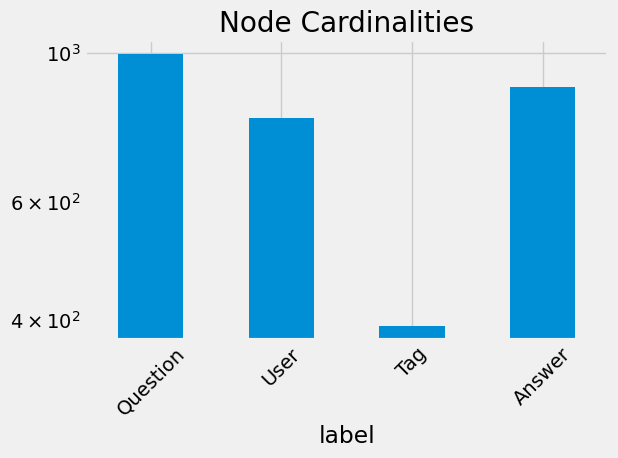

In [16]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

List of types of relationships

In [17]:
result = {"Relationship Type": [], "Count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as Count"
    count = graph.run(query).to_data_frame().iloc[0]['Count']
    result["Relationship Type"].append(relationship_type)
    result["Count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("Count")


,Relationship Type,Count
2,ANSWERED,889
3,PROVIDED,889
0,ASKED,997
1,TAGGED,2840


Visualization of the Relationship count result

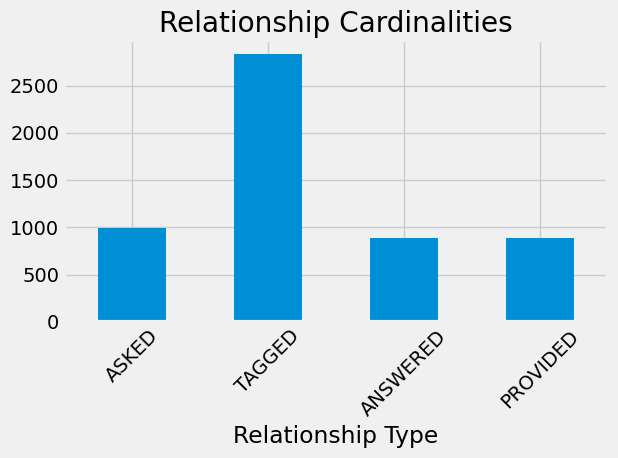

In [18]:
rels_df.plot(kind='bar', x='Relationship Type', y='Count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

List of labels

In [19]:
query = """ MATCH (n) RETURN labels(n) as Label, count(*) as Count; """
result = pd.DataFrame(graph.run(query).to_data_frame())
result_dict = {'Label': [], 'Count': []}
result['Label'] = [line for line in result['Label'].str[0]]
result['Count'] = [line for line in result['Count']]
result_df = pd.DataFrame(result)
result_df

,Label,Count
0,Question,997
1,User,799
2,Tag,392
3,Answer,889


Visualization of Label vs Count

<AxesSubplot: title={'center': 'Label vs Count'}, xlabel='Label'>

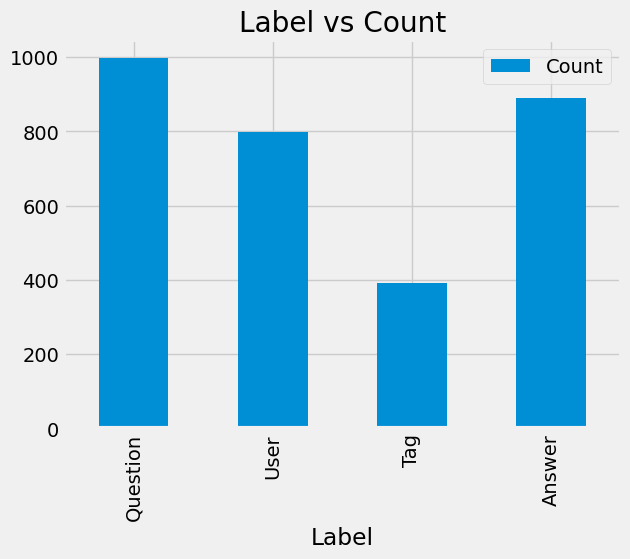

In [20]:
result_df.plot(x='Label', y='Count', kind='bar', title='Label vs Count')

Top 15 Tagged items and their counts

In [21]:
query = """ MATCH ()-[:TAGGED]->(t:Tag) RETURN t.name as `Tagged Name`,count(*) as Posts order by Posts desc limit 15;"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Tagged Name,Posts
0,neo4j,997
1,cypher,463
2,graph-databases,80
3,neo4j-apoc,78
4,python,65
5,spring-data-neo4j,57
6,java,45
7,database,40
8,graph,36
9,memgraphdb,27


Visualization of Tag vs Post

<AxesSubplot: title={'center': 'Tag vs Post'}, xlabel='Tagged Name'>

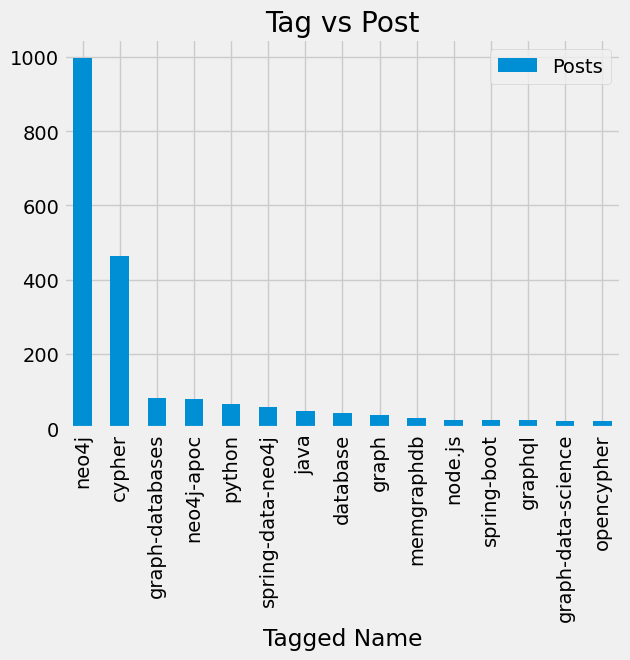

In [22]:
result.plot(x='Tagged Name', y='Posts', kind='bar', title='Tag vs Post')

Top ten users asking questions

In [23]:
query = """MATCH (User:User)-[:ASKED]->() RETURN User.display_name as Name, count(*) as Posts ORDER by Posts desc limit 10;"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Name,Posts
0,alexanoid,39
1,drdot,28
2,Vincenzo,10
3,le Minh Nguyen,10
4,JAMSHAID,9
5,SteveS,8
6,daylightisminetocommand,7
7,MichaelE,6
8,Lakeside52,6
9,Christos Grigoriadis,6


Visualiztion of Top ten users vs posts

<AxesSubplot: title={'center': 'User vs Posts'}, xlabel='Name'>

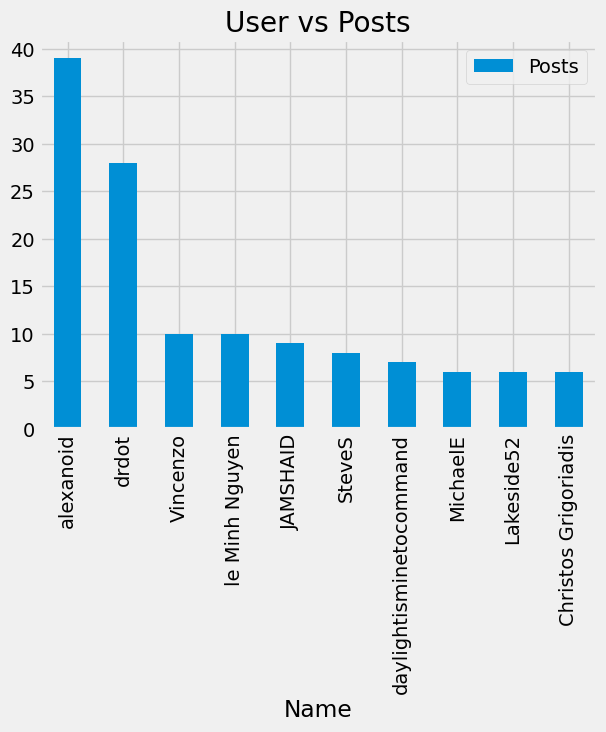

In [24]:
result.plot(x='Name', y='Posts', kind='bar', title='User vs Posts')

Top ten users answering

In [25]:
query = """MATCH (User:User)-[:PROVIDED]->() RETURN User.display_name as Name, count(*) as Posts ORDER by Posts desc limit 10;"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Name,Posts
0,jose_bacoy,160
1,Charchit Kapoor,148
2,cybersam,68
3,Tomaž Bratanič,48
4,Graphileon,47
5,Michael Hunger,36
6,Christophe Willemsen,29
7,William Lyon,18
8,Vincent Rupp,14
9,nimrod serok,13


Visualization of top ten users answering posts

<AxesSubplot: title={'center': 'Top ten users answering posts'}, xlabel='Name'>

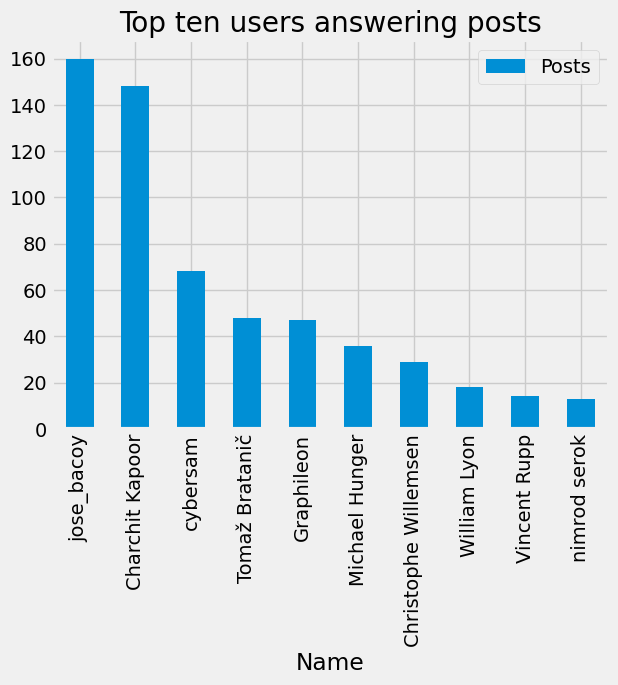

In [26]:
result.plot(x='Name', y='Posts', kind='bar', title='Top ten users answering posts')

Top days for answering questions

In [27]:
query = """MATCH (q:Question) RETURN apoc.date.format(q.creation_date,'s','EE') as Day, count(*) as Frequency ORDER BY Frequency desc;"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Day,Frequency
0,Wed,180
1,Tue,176
2,Thu,170
3,Mon,153
4,Fri,131
5,Sun,100
6,Sat,87


Visualization of top ten days for answering questions

<AxesSubplot: title={'center': 'Top ten days for answering questions'}, xlabel='Day'>

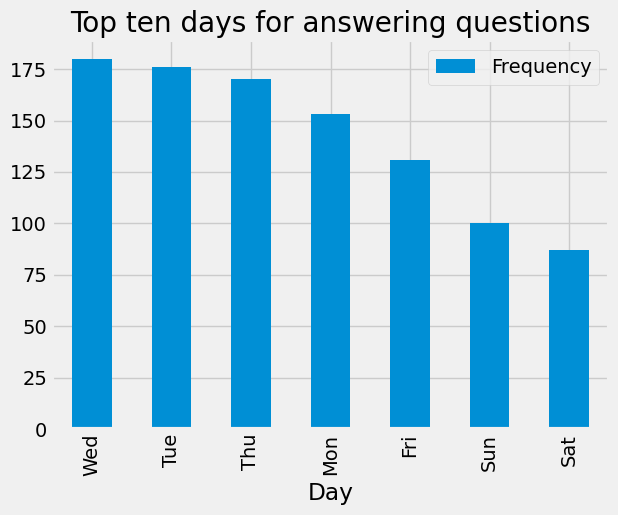

In [28]:
result.plot(x='Day', y='Frequency', kind='bar', title='Top ten days for answering questions')

Top ten tags for the user: "cybersam"

In [29]:
query = """MATCH (u:User)-[:PROVIDED]->()-[:ANSWERED]->()-[:TAGGED]->(t:Tag) WHERE u.display_name = "cybersam" RETURN t.name as `Tag`,count(*) as Posts order by Posts desc limit 10;"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Tag,Posts
0,neo4j,68
1,cypher,43
2,opencypher,9
3,memgraphdb,8
4,neo4j-apoc,8
5,graph-databases,7
6,database,2
7,shortest-path,2
8,neo4j-driver,2
9,python,2


Visualization for top ten tags for the user: "cybersam"

<AxesSubplot: title={'center': 'Top ten tags for the user: "cybersam"'}, xlabel='Tag'>

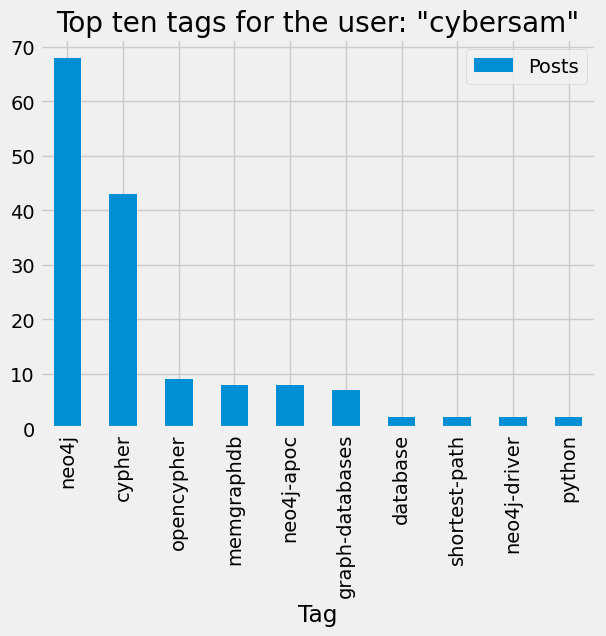

In [30]:
result.plot(x='Tag', y='Posts', kind='bar', title='Top ten tags for the user: "cybersam"')

Tags for unanswered questions

In [31]:
query = """MATCH (q:Question)-[:TAGGED]->(t:Tag) WHERE not t.name IN ['neo4j','cypher'] and not (q)<-[:ANSWERED]-() RETURN t.name as Tag, count(*) as Posts ORDER BY Posts desc LIMIT 10;""" 
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Tag,Posts
0,java,23
1,spring-data-neo4j,23
2,python,20
3,graph-databases,19
4,spring-boot,15
5,database,14
6,spring,12
7,graphql,10
8,neo4j-apoc,10
9,graph,9


Visualization of tags for unanswered questions

<AxesSubplot: title={'center': 'Tags for unanswered questions'}, xlabel='Tag'>

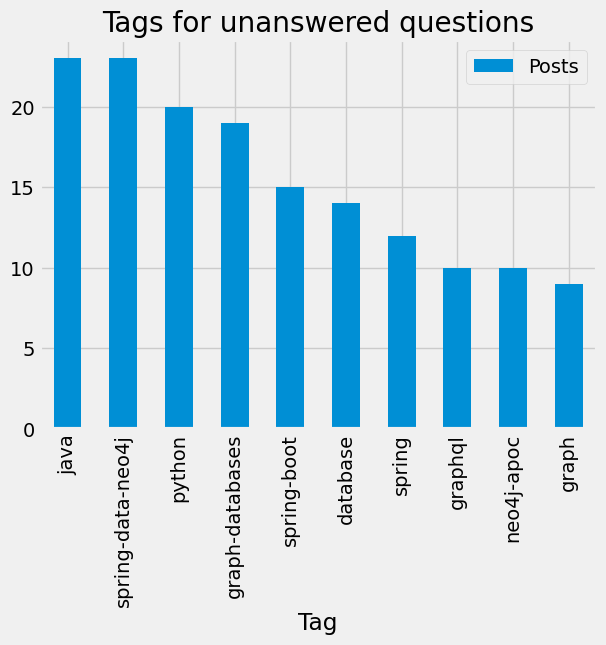

In [32]:
result.plot(x='Tag', y='Posts', kind='bar', title='Tags for unanswered questions')

Tag correlations

In [33]:
query = """MATCH (t1:Tag)<-[:TAGGED]-()-[:TAGGED]->(t2:Tag) WHERE id(t1) < id(t2) and t1.name <> 'neo4j' and t2.name <> 'neo4j' RETURN t1.name as `Tag-1`, t2.name as `Tag-2`,count(*) as Frequency ORDER BY Frequency desc LIMIT 10;""" 
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Tag-1,Tag-2,Frequency
0,cypher,graph-databases,47
1,cypher,neo4j-apoc,45
2,cypher,memgraphdb,23
3,cypher,opencypher,18
4,cypher,graph,18
5,python,cypher,17
6,memgraphdb,opencypher,16
7,java,spring-data-neo4j,16
8,cypher,database,16
9,spring-data-neo4j,spring,14


User engagement for User "InverseFalcon"

In [34]:
query = """MATCH (t1:Tag)<-[:TAGGED]-()-[:TAGGED]->(t2:Tag)
WHERE id(t1) < id(t2) and t1.name <> 'neo4j' and t2.name <> 'neo4j'
WITH t1, t2,count(*) as freq  where freq > 3
RETURN t1,t2, apoc.create.vRelationship(t1,'OCCURRED',{freq:freq},t2) as rel;""" 
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,t1,t2,rel
0,{'name': 'python'},{'name': 'cypher'},{'freq': 17}
1,{'name': 'cypher'},{'name': 'memgraphdb'},{'freq': 23}
2,{'name': 'cypher'},{'name': 'neo4j-apoc'},{'freq': 45}
3,{'name': 'python'},{'name': 'py2neo'},{'freq': 11}
4,{'name': 'cypher'},{'name': 'neo4j-ogm'},{'freq': 5}
5,{'name': 'graphql'},{'name': 'neo4j-graphql-js'},{'freq': 10}
6,{'name': 'cypher'},{'name': 'database'},{'freq': 16}
7,{'name': 'python'},{'name': 'json'},{'freq': 4}
8,{'name': 'cypher'},{'name': 'graph-theory'},{'freq': 8}
9,{'name': 'cypher'},{'name': 'java'},{'freq': 9}


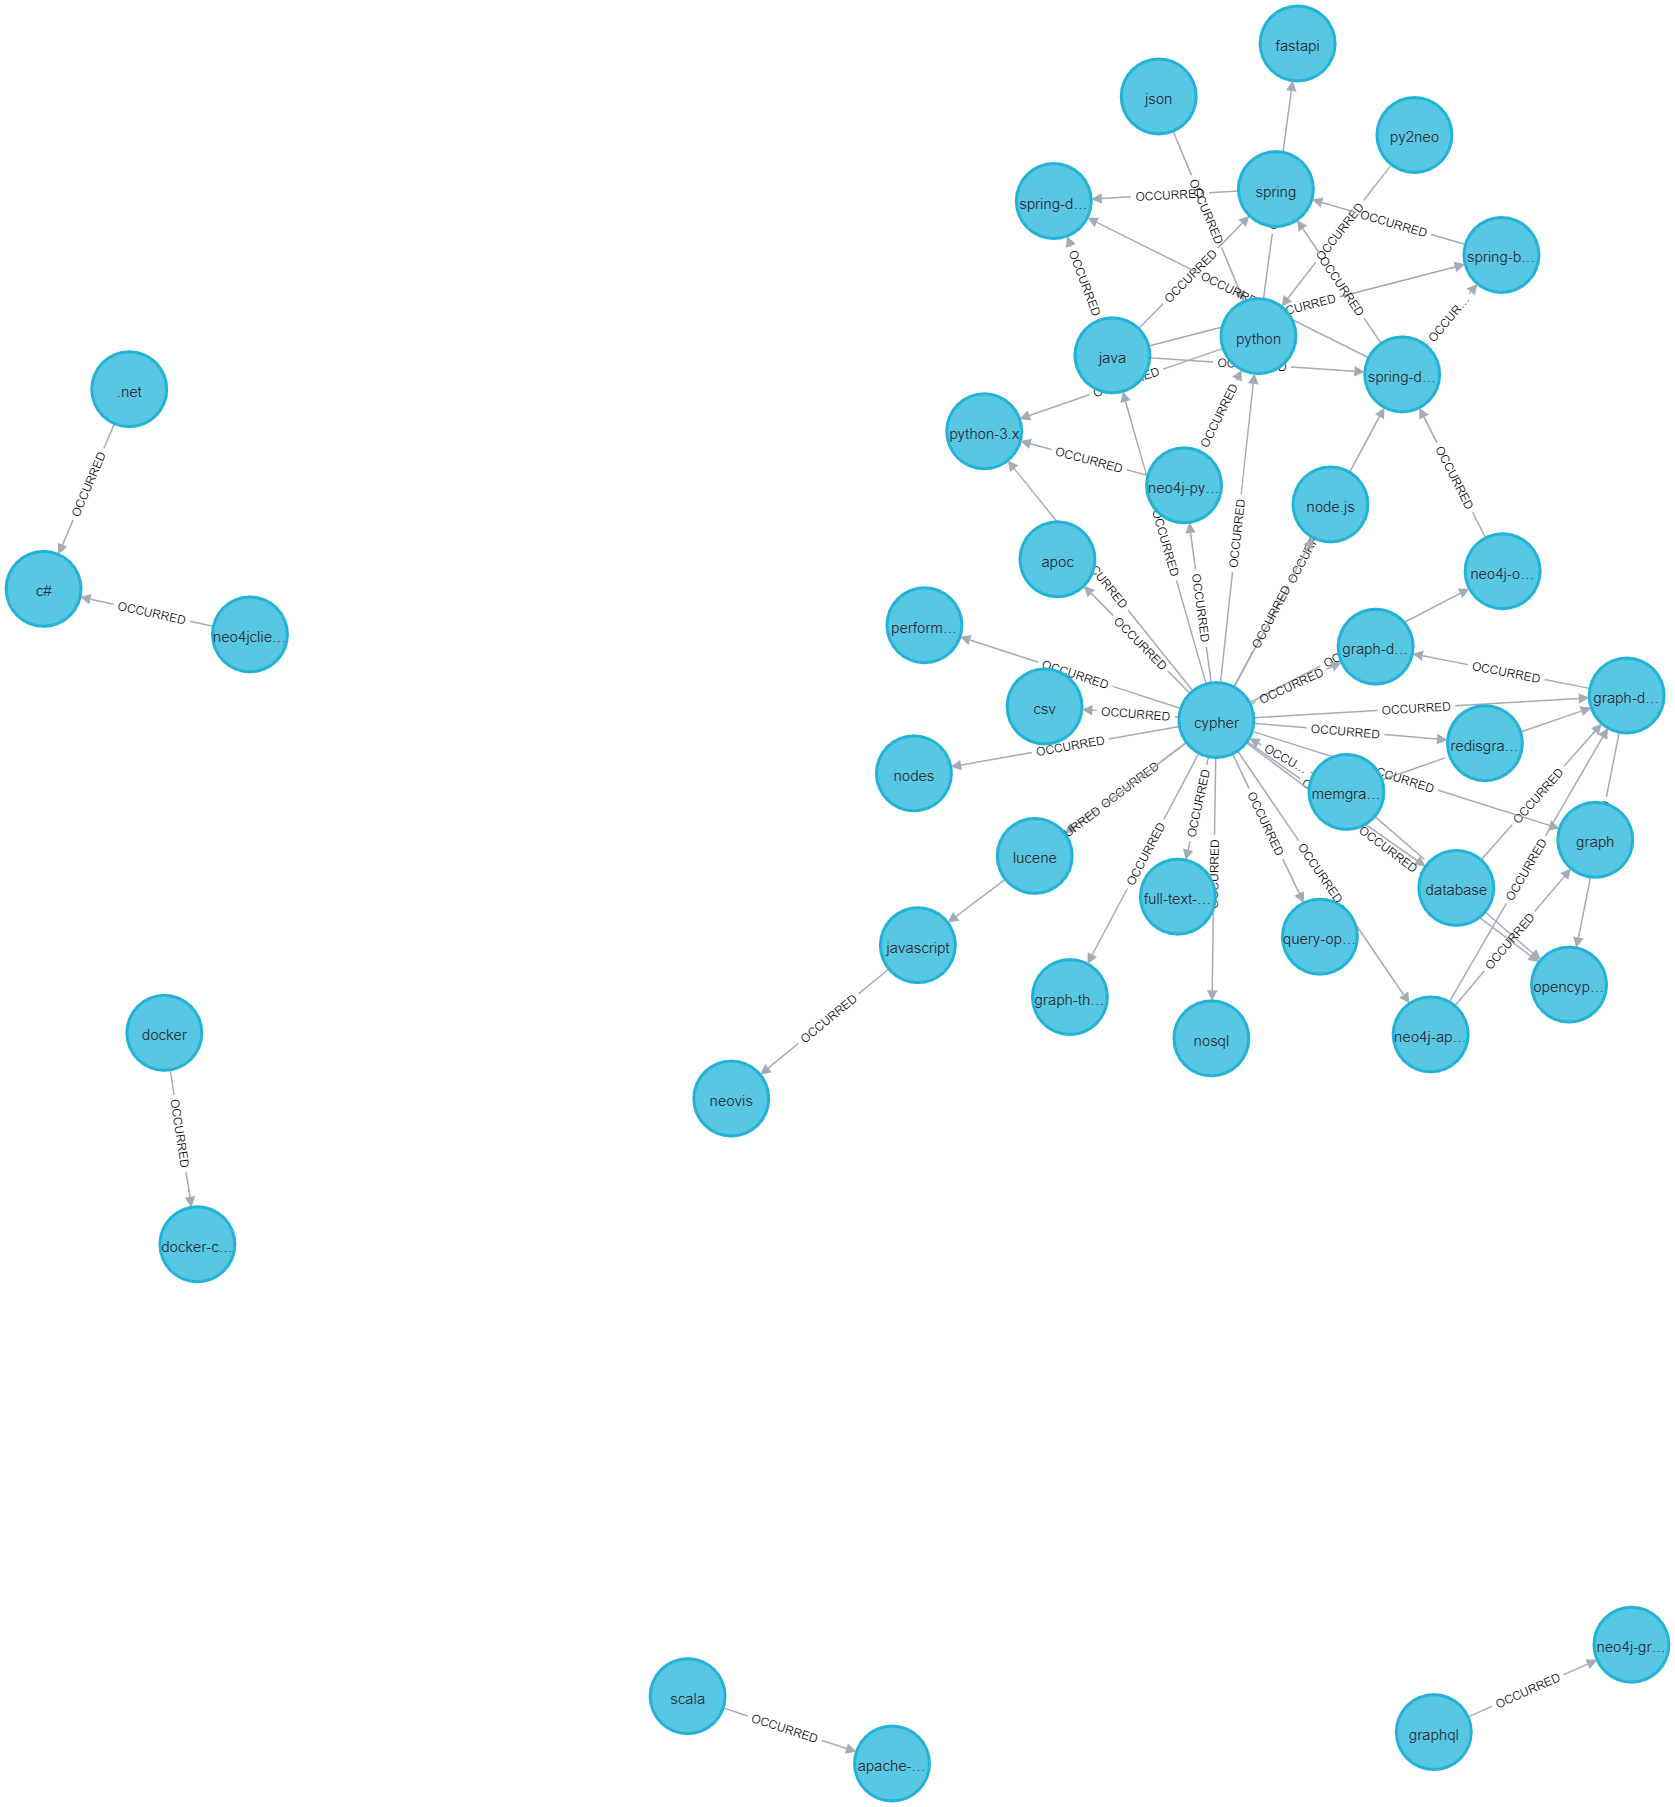

# Section-3: Applying Graph Algorithm

Computing Betweenness Centrality Algorithm

In [35]:
graph.run("""
CALL gds.betweenness.write('myGraph', { writeProperty: 'betweenness' })
YIELD centralityDistribution, nodePropertiesWritten
RETURN centralityDistribution.min AS minimumScore, centralityDistribution.mean AS meanScore, nodePropertiesWritten;
""").to_data_frame()

ClientError: [Procedure.ProcedureCallFailed] Failed to invoke procedure `gds.betweenness.write`: Caused by: java.util.NoSuchElementException: Graph with name `myGraph` does not exist on database `neo4j`. It might exist on another database.

Computing Clossness

In [36]:
graph.run("""
CALL gds.alpha.closeness.write({
  nodeProjection: 'Question',
  relationshipProjection: 'TAGGED',
  writeProperty: 'closeness'
}) YIELD nodes, writeProperty;
""").to_data_frame()

,nodes,writeProperty
0,997,closeness


In [37]:
graph.run("""
CALL gds.alpha.closeness.stream({
  nodeProjection: 'Question',
  relationshipProjection: 'TAGGED',
  improved:true 
})
YIELD nodeId, centrality
RETURN gds.util.asNode(nodeId).id AS user, centrality
ORDER BY centrality DESC;
""").to_data_frame()

,user,centrality
0,76024415,0.000
1,76017666,0.000
2,76014286,0.000
3,76013293,0.000
4,76012714,0.000
...,...,...
992,75143948,0.000
993,75132155,0.000
994,75127693,0.000
995,75122843,0.000


In [38]:
graph.run("""
CALL gds.alpha.closeness.harmonic.stream({
  nodeProjection: 'Question',
  relationshipProjection: 'TAGGED'
})
YIELD nodeId, centrality
RETURN gds.util.asNode(nodeId).id AS user, centrality
ORDER BY centrality DESC
;
""").to_data_frame()

,user,centrality
0,76024415,0.000
1,76017666,0.000
2,76014286,0.000
3,76013293,0.000
4,76012714,0.000
...,...,...
992,75143948,0.000
993,75132155,0.000
994,75127693,0.000
995,75122843,0.000


In [ ]:
Computing PageRank

In [39]:
graph.run("""
CALL gds.pageRank.write('myGraph', {
  maxIterations: 20,
  dampingFactor: 0.85,
  writeProperty: 'pagerank'
})
YIELD nodePropertiesWritten, ranIterations;
""").to_data_frame()

ClientError: [Procedure.ProcedureCallFailed] Failed to invoke procedure `gds.pageRank.write`: Caused by: java.util.NoSuchElementException: Graph with name `myGraph` does not exist on database `neo4j`. It might exist on another database.